Libraries needed in this algorithm

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from glob import glob
import gc
gc.enable()
import os

# wavenet
from keras.layers import Input, AveragePooling1D, Conv1D, Multiply, Add, Activation, GlobalAveragePooling1D, LSTM
from keras.layers import CuDNNLSTM as LSTM
from keras.layers import Dense, Dropout, Conv1D, BatchNormalization#, LSTM

from keras.models import Model
from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from ast import literal_eval
import tensorflow as tf

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print(len(get_available_gpus()))

1


Parameters

In [3]:
batch_size = 4000
total_size = 2500
size_train = 10
size_valid = 5
size_test = 5
size_ensemble = 5

The following lines read the path of all CSV files in train_simplified

In [4]:
paths = glob(os.path.join('.', 'data', '*.csv'))
print(paths[:10])
column_names = ['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word']

['./data/lollipop.csv', './data/bench.csv', './data/dresser.csv', './data/scorpion.csv', './data/tractor.csv', './data/peanut.csv', './data/harp.csv', './data/dragon.csv', './data/nose.csv', './data/compass.csv']


The following function receives the data as separate strokes each one with seperate vertical and horizontal coordinates. The goal of this function is to change each coming sample to a list of vertical and horiontal pair of coordinates. Each pair has an id of 2 or 1. 2 means this is the start point of the stroke and 1 means the continuing points of a stroke. The modified samples are also stacked.

In [5]:
def raw_2_xy_stroke(df):
    df = literal_eval(df) # to change string to list

    xys = []
    for ind, strokes in enumerate(df):

        # change strokes to sequential xy points        
        x = strokes[0]
        y = strokes[1]
        
        for j, (xj, yj) in enumerate(zip(x,y)):
            ID = 2 if j==0 else 1  # change the id of stroke. 2: first point of stroke, 1: continuing points
            xys.append([xj, yj, ID]) # (x, y, id of stroke)
    
    xys = np.stack(xys)
    # zero pading
    df = pad_sequences(xys.swapaxes(0, 1), maxlen=200, padding='post').swapaxes(0, 1)
    
    return df

read_batch function reads "max_rows" number of samples from the start_row and randomly selects "samples" number of them. The data includes several columns of drawing, country of user, id, category of drawing and so on. In this function, only the two columns of drawing and word are used for the learning process. **drawing** is the input data and **word** is the category of drawing. Afterwards, the list of samples are sent to **raw_2_xy_stroke** function to chang each smaple to a 2D vector of strokes with the format [x, y, id of stroke].

In [6]:
def read_from_csv(lower, length, size):
    all_df = []
    for path in paths:
        #n = sum(1 for line in open(path)) - 1 # find the number of samples in the path
        #inds = np.random.choice(range(lower, upper), size = size)
        #keep = list(range(0, n))
        #skip = list(set(inds)-set(keep))
        df = pd.read_csv(path, nrows=length, skiprows=lower)
        df.columns=column_names
        all_df += [df.sample(size)[['drawing', 'word']]]
    return pd.concat(all_df)  

The information about the number of sample and the first row of data in a CSV file is specified. Then the **read_from_csv** function is called to read the requested amount of data. Then, the data is transformed to xy-coordinate form with a third column for the id of stroke. The data is read in whole and later it is split into 4 sets of training, validation, testing and ensemble testing using **train_test_split** function.

In [56]:
"""df_train = read_from_csv(0, 5000, size_train)
df_train['drawing'] = df_train['drawing'].map(raw_2_xy_stroke)

df_valid = read_from_csv(5000, 2500, size_valid)
df_valid['drawing'] = df_valid['drawing'].map(raw_2_xy_stroke)

df_test = read_from_csv(7500, 2500, size_test)
df_test['drawing'] = df_test['drawing'].map(raw_2_xy_stroke)

df_ensemble = read_from_csv(10000, 2500, size_ensemble)
df_ensemble['drawing'] = df_ensemble['drawing'].map(raw_2_xy_stroke)
"""

In [7]:
from sklearn.model_selection import train_test_split
df_train = read_from_csv(0, 5000, total_size)
df_train['drawing'] = df_train['drawing'].map(raw_2_xy_stroke)

LabelEncoder() is used to find the labels. This function maps each label to a number in range of [1, number of category].

In [8]:
label_encoder = LabelEncoder()
label_encoder.fit(df_train['word'])
print('The number of words is ', len(label_encoder.classes_))
print(', '.join([x for x in label_encoder.classes_][:20]))

The number of words is  340
The Eiffel Tower, The Great Wall of China, The Mona Lisa, airplane, alarm clock, ambulance, angel, animal migration, ant, anvil, apple, arm, asparagus, axe, backpack, banana, bandage, barn, baseball, baseball bat


The following function creates the input X and the label y. 

In [9]:
X= np.stack(df_train['drawing'], 0)
y = to_categorical(label_encoder.transform(df_train['word'].values))  

In [10]:
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size = 0.4,  random_state=0)
X_valid, X_rest, y_valid, y_rest = train_test_split(X_rest, y_rest, test_size = 0.66,  random_state=0)
X_test, X_ensemble, y_test, y_ensemble = train_test_split(X_rest, y_rest, test_size = 0.5,  random_state=0)

In [77]:
print("Train size: ", len(X_train))
print("Validation size: ", len(X_valid))
print("Test size: ", len(X_test))
print("Ensemble size: ", len(X_ensemble))

Train size:  510000
Validation size:  115600
Test size:  112200
Ensemble size:  112200


In [71]:
#print(y_train)
"""from collections import Counter
new=[]
for i in range(len(y_test)):
    new.append(label_encoder.classes_[np.argmax(y_test[i])])
print(Counter(new))    
"""

'from collections import Counter\nnew=[]\nfor i in range(len(y_test)):\n    new.append(label_encoder.classes_[np.argmax(y_test[i])])\nprint(Counter(new))    \n'

In [60]:
"""
X_train = np.stack(xys_train['drawing'], 0)
y_train = to_categorical(label_encoder.transform(xys_train['word'].values))  

X_valid = np.stack(xys_valid['drawing'], 0)
y_valid = to_categorical(label_encoder.transform(xys_valid['word'].values)) 

X_test = np.stack(xys_test['drawing'], 0)
y_test = to_categorical(label_encoder.transform(xys_test['word'].values)) 

X_ensemble = np.stack(xys_ensemble['drawing'], 0)
y_ensemble = to_categorical(label_encoder.transform(xys_ensemble['word'].values)) 
print(X_train.shape)
"""

"\nX_train = np.stack(xys_train['drawing'], 0)\ny_train = to_categorical(label_encoder.transform(xys_train['word'].values))  \n\nX_valid = np.stack(xys_valid['drawing'], 0)\ny_valid = to_categorical(label_encoder.transform(xys_valid['word'].values)) \n\nX_test = np.stack(xys_test['drawing'], 0)\ny_test = to_categorical(label_encoder.transform(xys_test['word'].values)) \n\nX_ensemble = np.stack(xys_ensemble['drawing'], 0)\ny_ensemble = to_categorical(label_encoder.transform(xys_ensemble['word'].values)) \nprint(X_train.shape)\n"

# Visualization

To visualize a sample from the database and show its raw format as well as the final strocke vector.

In [11]:
def plot_drawing(ax, x, y_):
    x = x[x[:,2]>0, :] 
    idx = np.cumsum(x[:,2]-1)
    for i in np.unique(idx):
        ax.plot(x[idx==i,0], np.max(x[:,1])-x[idx==i,1], '.-')
    ax.axis('off')
    ax.set_title(label_encoder.classes_[np.argmax(y_)])

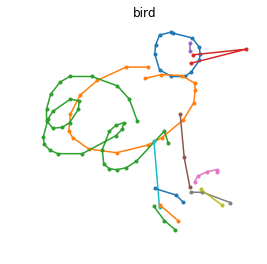

In [132]:
fig, ax = plt.subplots(1,1, figsize = (4, 4))

path = paths[104]
df = pd.read_csv(path, nrows=1, skiprows=10)
df.columns=column_names
raw_df = df
df = [df[['drawing', 'word']]]
df = pd.concat(df)
df['drawing'] = df['drawing'].map(raw_2_xy_stroke)
 
X_temp = np.stack(df['drawing'], 0)
y_temp = to_categorical(label_encoder.transform(df['word'].values))  
#print(X_temp)

plot_drawing(ax, X_temp[0], y_temp[0])


In [63]:
# raw sample
print(raw_df)

  countrycode                                            drawing  \
0          AU  [[[160, 146, 141, 140, 146, 161, 178, 186, 196...   

             key_id  recognized                   timestamp  word  
0  5358827060854784        True  2017-03-25 07:45:19.576680  bird  


In [64]:
# final stroke vector
print(X_temp)

[[[160   0   2]
  [146   3   1]
  [141  14   1]
  [140  23   1]
  [146  40   1]
  [161  47   1]
  [178  47   1]
  [186  42   1]
  [196  30   1]
  [197  23   1]
  [196  16   1]
  [187   6   1]
  [163   1   1]
  [131  37   2]
  [104  37   1]
  [ 68  51   1]
  [ 46  67   1]
  [ 34  87   1]
  [ 32 105   1]
  [ 37 112   1]
  [ 57 124   1]
  [ 92 128   1]
  [131 120   1]
  [149 112   1]
  [176  93   1]
  [189  75   1]
  [191  61   1]
  [190  54   1]
  [174  46   1]
  [148  45   1]
  [128  49   1]
  [118  94   2]
  [108  71   1]
  [ 93  57   1]
  [ 61  47   1]
  [ 33  47   1]
  [ 21  53   1]
  [  9  66   1]
  [  4  82   1]
  [  4  94   1]
  [ 12 102   1]
  [ 24 101   1]
  [ 33  96   1]
  [ 44  82   1]
  [ 45  73   1]
  [ 34  71   1]
  [ 12  84   1]
  [  6  92   1]
  [  0 111   1]
  [  1 119   1]
  [  8 125   1]
  [ 18 129   1]
  [ 49 129   1]
  [ 91 110   1]
  [ 99 103   1]
  [101  96   1]
  [ 91  99   1]
  [ 83 105   1]
  [ 74 125   1]
  [ 76 140   1]
  [ 83 145   1]
  [ 92 146   1]
  [104 1

To plot a few samples of drawings. Different colors shows different strokes for a drawing. The catrgory of drawing which was asked from the user to sketch is also written as title.

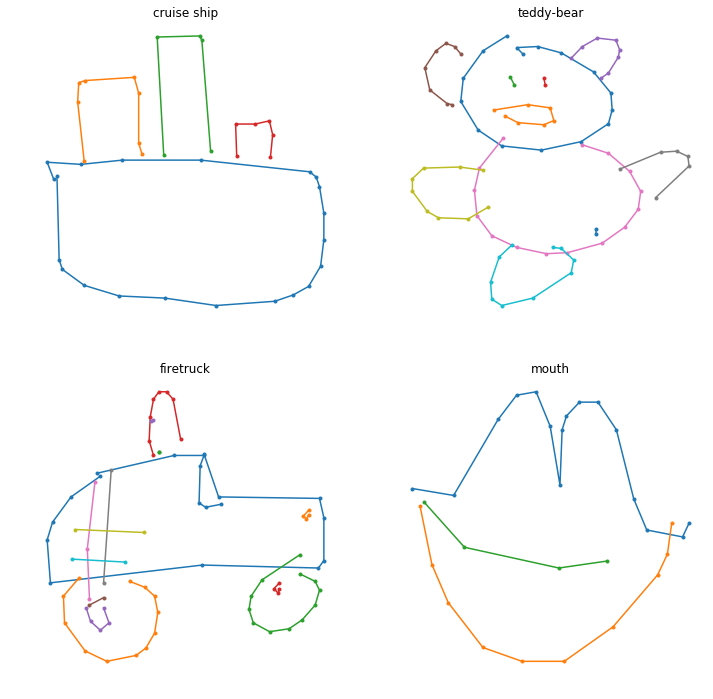

In [135]:
fig, axs = plt.subplots(2,2, figsize = (12, 12))
idxs = np.random.choice(range(X_train.shape[0]), size = 4)
for i, ax in zip(idxs, axs.flatten()):
    plot_drawing(ax, X_train[i], y_train[i])

# WaveNet

The WaveNet model is built using Keras. The residual block is designed based on the model presented by DeepMind group. It has two outputs of skip_connections and residual. The depth of the WaveNet is 8 which means 8 layers of dilated casual convolution with dilation rate [1, 2, 4, 8, 16, 32, 64, 128]. Since the application is classification, at the end of skip_connections add operation and 3 1D convolutions with AveragePooling1D, there is a final 1D convolutional layer which outputs the probability of all categories with a softmax function.

This implemented model of WaveNet here is inspired from https://www.kaggle.com/kmader/quickdraw-with-wavenet-classifier.

In [12]:
#k = 8 # number of dilated causal layers
input_size = X_train.shape[1:]
output_size = y_train[0].shape[0]
print(input_size)
print(output_size)
filters = 64
filters_final = 256
kernel_size_2 = 2
kernel_size_4 = 4
kernel_size_8 = 8
dilation_depth = 8

(200, 3)
340


In [13]:
# WaveNet Model

inpt = Input(shape=input_size)
in_layer = Conv1D(filters, kernel_size_2, padding='causal')(inpt)

def residual_block(inpt,dilation):
    # step by step based on the residual block diagram
    dilated_conv = Conv1D(filters, kernel_size_2, strides=1, padding='causal', dilation_rate=dilation)(inpt)
    tanh_out = Activation('tanh')(dilated_conv)
    sigmoid_out = Activation('sigmoid')(dilated_conv)
    multipy_out = Multiply()([tanh_out,sigmoid_out])
    oneDConv_out = Conv1D(filters, kernel_size_2, strides=1, padding='same')(multipy_out)
    
    skip_out = oneDConv_out
    residual = Add()([inpt, oneDConv_out])
    return skip_out, residual

# dilated layers
residual = in_layer
skip_connections = []
for i in range(dilation_depth):
    skip_out, residual = residual_block(residual,2**(i+1))
    skip_connections.append(skip_out)

# skip_connection process
add_out = Add()(skip_connections)
first_relu_out = Activation('relu')(add_out)

first_1DConv_out = Conv1D(filters, kernel_size_4, strides=1, padding='same')(first_relu_out)
second_relu_out = Activation('relu')(first_1DConv_out)

second_1DConv_out = Conv1D(filters, kernel_size_4, strides=1, padding='same')(second_relu_out) # we dont use softmax here yet
third_relu_out = Activation('relu')(second_1DConv_out)
first_average_pooling = AveragePooling1D(pool_size=4, strides=None, padding='same')(third_relu_out)

# additional 1D convolutional layer
out = Conv1D(filters_final, kernel_size_8, strides=1, padding='same')(first_average_pooling)
fourth_relu_out = Activation('relu')(out)
second_average_pooling = AveragePooling1D(pool_size=8, strides=None, padding='same')(fourth_relu_out)

# output layer
out = Conv1D(output_size, kernel_size_8, strides=1, padding='same')(second_average_pooling)
out = GlobalAveragePooling1D()(out)
out_layer = Activation(tf.nn.softmax)(out)

# final model and compilation
wavenet_model = Model(inpt, out_layer)
wavenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
wavenet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 3)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 200, 64)      448         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 200, 64)      8256        conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 200, 64)      0           conv1d_2[0][0]                   
__________________________________________________________________________________________________
activation

The weights of best model must be saved after every epoch, therefore ModelCheckpoint is used to save the best model in the current directory. 

In [14]:
# callbacks

checkpointer = ModelCheckpoint(filepath='wavenet_weights.best.wavenet.hdf5', 
                               verbose=1, save_best_only=True)


Here, the WaveNet model is trainied.

In [82]:
# training
wavenet_model.fit(X_train, np.array(y_train),
          validation_data=(X_valid, np.array(y_valid)), epochs=50, 
          batch_size=batch_size, callbacks=[checkpointer], verbose=1)

Train on 510000 samples, validate on 115600 samples
Epoch 1/50
510000/510000 [==============================] - 349s 684us/step - loss: 5.0216 - acc: 0.0519 - val_loss: 4.4034 - val_acc: 0.1135

Epoch 00001: val_loss improved from inf to 4.40339, saving model to wavenet_weights.best.wavenet.hdf5
Epoch 2/50
510000/510000 [==============================] - 325s 637us/step - loss: 3.9702 - acc: 0.1750 - val_loss: 3.5225 - val_acc: 0.2408

Epoch 00002: val_loss improved from 4.40339 to 3.52249, saving model to wavenet_weights.best.wavenet.hdf5
Epoch 3/50
510000/510000 [==============================] - 325s 638us/step - loss: 3.3039 - acc: 0.2827 - val_loss: 3.0922 - val_acc: 0.3177

Epoch 00003: val_loss improved from 3.52249 to 3.09224, saving model to wavenet_weights.best.wavenet.hdf5
Epoch 4/50
510000/510000 [==============================] - 325s 638us/step - loss: 2.9246 - acc: 0.3507 - val_loss: 2.8106 - val_acc: 0.3715

Epoch 00004: val_loss improved from 3.09224 to 2.81056, saving

510000/510000 [==============================] - 325s 637us/step - loss: 1.4595 - acc: 0.6422 - val_loss: 1.7415 - val_acc: 0.5907

Epoch 00035: val_loss did not improve from 1.73738
Epoch 36/50
510000/510000 [==============================] - 325s 638us/step - loss: 1.4466 - acc: 0.6453 - val_loss: 1.7246 - val_acc: 0.5923

Epoch 00036: val_loss improved from 1.73738 to 1.72462, saving model to wavenet_weights.best.wavenet.hdf5
Epoch 37/50
510000/510000 [==============================] - 325s 637us/step - loss: 1.4349 - acc: 0.6478 - val_loss: 1.7048 - val_acc: 0.6000

Epoch 00037: val_loss improved from 1.72462 to 1.70479, saving model to wavenet_weights.best.wavenet.hdf5
Epoch 38/50
510000/510000 [==============================] - 325s 638us/step - loss: 1.4163 - acc: 0.6516 - val_loss: 1.7082 - val_acc: 0.5974

Epoch 00038: val_loss did not improve from 1.70479
Epoch 39/50
510000/510000 [==============================] - 325s 638us/step - loss: 1.4069 - acc: 0.6544 - val_loss: 1.69

The weights of the model are loaded from the directory they are saved in and the overall accuracy is calculated for the testing set.

In [15]:
# testing
wavenet_model.load_weights('wavenet_weights.best.wavenet.hdf5')
wavenet_result = wavenet_model.evaluate(X_test, y_test, batch_size = batch_size)
print("Accuracy of WaveNet on test set is ",wavenet_result)

112200/112200 [==============================] - 30s 269us/step
Accuracy of WaveNet on test set is  [1.5340809354595109, 0.63237967933138]


The confusion matrix shows the true and false classifiation of each category of drawing. It is also used here to calculate the accuracy of the WaveNet for each category.

In addition to accuracy, other evaluation metrics including precision, recall and f1-score are computed for the testing set using classification_report. 

                         precision    recall  f1-score   support

       The Eiffel Tower       0.75      0.82      0.78       301
The Great Wall of China       0.58      0.36      0.44       321
          The Mona Lisa       0.75      0.85      0.79       349
               airplane       0.58      0.79      0.67       308
            alarm clock       0.66      0.69      0.67       337
              ambulance       0.48      0.52      0.50       337
                  angel       0.69      0.72      0.70       331
       animal migration       0.52      0.46      0.49       356
                    ant       0.59      0.72      0.65       320
                  anvil       0.71      0.75      0.73       302
                  apple       0.77      0.88      0.82       336
                    arm       0.60      0.69      0.65       356
              asparagus       0.61      0.57      0.59       328
                    axe       0.61      0.67      0.63       323
               backpack 

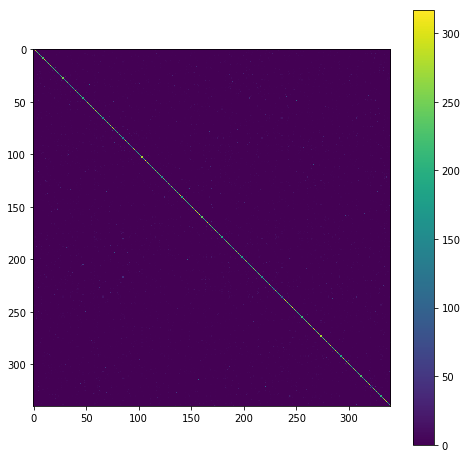

In [16]:
# evaluation metrics
test_cat = np.argmax(y_test, 1)
pred_y = wavenet_model.predict(X_test, batch_size = batch_size)
pred_cat = np.argmax(pred_y, 1)

cm_wave = confusion_matrix(test_cat, pred_cat)

plt.figure(figsize=(8, 8))
plt.imshow(cm_wave, interpolation='nearest')
plt.colorbar()

cm = cm_wave.astype('float') / cm_wave.sum(axis=1)[:, np.newaxis]
cm_wavenet = cm.diagonal()
#print("Accuracy of WaveNet for each category",cm_wavenet)

print(classification_report(test_cat, pred_cat, target_names = [x for x in label_encoder.classes_]))

print("Three top accuracies: ", sorted(cm_wavenet)[-3:])

# LSTM

The LSTM is modeled here using Keras library. The LSTM module from **CuDNNLSTM** uses the library of NVIDIA for GPU and is faster than the regular LSTM module of Keras. Therefore, if any GPU is available this module from CuDNNLSTM is called. The model starts with three 1D convolutional layers for the feature extraction and abstraction. Then, two LSTM layers are added after which three fully connected layers are used to do the task of classification. That is identical to the neural network designed by Google in order to use it as benchmark for comparison.

This implemented model of LSTM here is inspired from https://www.kaggle.com/kmader/quickdraw-baseline-lstm-reading-and-submission.

In [17]:
activation = 'relu'
drop = 0.3 # 0.1 # 0.2 # 
filters = 32
kernel_size = 3
n_lstm = 128
dense_size = y_train[0].shape[0]

In [18]:
input_tensor = Input(shape=input_size)
out= BatchNormalization(input_shape=(None,)+input_size)(input_tensor)

# convolutional layer for preprocessing
out = Conv1D(48, (5,), padding='same')(out)
#out = Activation(activation)(out)
out = Dropout(drop)(out)

out = Conv1D(64, (5,), padding='same')(out)
#out = Activation(activation)(out)
out = Dropout(drop)(out)

out = Conv1D(96, (3,), padding='same')(out)
#out = Activation(activation)(out)
out = Dropout(drop)(out)

# lstm layers
out = LSTM(n_lstm, return_sequences = True)(out)
out = Dropout(drop)(out)
#out = LSTM(n_lstm, return_sequences = True)(out)
#out = Dropout(drop)(out)
out = LSTM(n_lstm, return_sequences = False)(out)

# classification layer
out = Dense(512)(out)
out = Dropout(drop)(out)
out = Dense(dense_size)(out)
out = Activation('softmax')(out)

# final model and compilation
lstm_model = Model(input_tensor, out)
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 200, 3)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 200, 3)            12        
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 200, 48)           768       
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 48)           0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 200, 64)           15424     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200, 64)           0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 200, 96)           18528     
__________

The weights of best model must be saved after every epoch, therefore ModelCheckpoint is used to save the best model in the current directory. 


In [19]:
# callbacks
checkpointer = ModelCheckpoint(filepath='lstm_weights.best.lstm.hdf5', 
                               verbose=1, save_best_only=True)


Here, the LSTM model is trainied.

In [88]:
# training
lstm_model.fit(X_train, np.array(y_train),
          validation_data=(X_valid, np.array(y_valid)), epochs=50, 
          batch_size=batch_size, callbacks=[checkpointer], verbose=1)

Train on 510000 samples, validate on 115600 samples
Epoch 1/50
510000/510000 [==============================] - 203s 398us/step - loss: 5.8295 - acc: 0.0033 - val_loss: 5.8112 - val_acc: 0.0061

Epoch 00001: val_loss improved from inf to 5.81119, saving model to lstm_weights.best.lstm.hdf5
Epoch 2/50
510000/510000 [==============================] - 198s 388us/step - loss: 5.5907 - acc: 0.0083 - val_loss: 5.4839 - val_acc: 0.0131

Epoch 00002: val_loss improved from 5.81119 to 5.48392, saving model to lstm_weights.best.lstm.hdf5
Epoch 3/50
510000/510000 [==============================] - 198s 388us/step - loss: 5.4095 - acc: 0.0149 - val_loss: 5.3928 - val_acc: 0.0163

Epoch 00003: val_loss improved from 5.48392 to 5.39279, saving model to lstm_weights.best.lstm.hdf5
Epoch 4/50
510000/510000 [==============================] - 198s 389us/step - loss: 5.3796 - acc: 0.0161 - val_loss: 5.2785 - val_acc: 0.0194

Epoch 00004: val_loss improved from 5.39279 to 5.27851, saving model to lstm_wei

510000/510000 [==============================] - 199s 390us/step - loss: 1.9127 - acc: 0.5281 - val_loss: 1.7379 - val_acc: 0.5709

Epoch 00035: val_loss improved from 1.77951 to 1.73785, saving model to lstm_weights.best.lstm.hdf5
Epoch 36/50
510000/510000 [==============================] - 199s 390us/step - loss: 1.8911 - acc: 0.5335 - val_loss: 1.7083 - val_acc: 0.5777

Epoch 00036: val_loss improved from 1.73785 to 1.70826, saving model to lstm_weights.best.lstm.hdf5
Epoch 37/50
510000/510000 [==============================] - 198s 388us/step - loss: 1.8682 - acc: 0.5379 - val_loss: 1.7006 - val_acc: 0.5800

Epoch 00037: val_loss improved from 1.70826 to 1.70059, saving model to lstm_weights.best.lstm.hdf5
Epoch 38/50
510000/510000 [==============================] - 199s 390us/step - loss: 1.8515 - acc: 0.5411 - val_loss: 1.6881 - val_acc: 0.5820

Epoch 00038: val_loss improved from 1.70059 to 1.68806, saving model to lstm_weights.best.lstm.hdf5
Epoch 39/50
510000/510000 [=========

The weights of the model are loaded from the directory they are saved in and the overall accuracy is calculated for the testing set.

In [20]:
# testing
lstm_model.load_weights('lstm_weights.best.lstm.hdf5')
lstm_result = lstm_model.evaluate(X_test, y_test, batch_size = batch_size)
print("Accuracy of LSTM on test set is ",lstm_result)

112200/112200 [==============================] - 13s 120us/step
Accuracy of LSTM on test set is  [1.5223765118236847, 0.6185383269706087]


The confusion matrix shows the true and false classification of each category of drawing. It is also used here to calculate the accuracy of the LSTM for each category.

In addition to accuracy, other evaluation metrics including precision, recall and f1-score are computed for the testing set using classification_report. 

                         precision    recall  f1-score   support

       The Eiffel Tower       0.78      0.77      0.77       301
The Great Wall of China       0.51      0.32      0.39       321
          The Mona Lisa       0.62      0.89      0.73       349
               airplane       0.71      0.68      0.69       308
            alarm clock       0.67      0.61      0.64       337
              ambulance       0.56      0.37      0.44       337
                  angel       0.65      0.73      0.69       331
       animal migration       0.47      0.63      0.54       356
                    ant       0.71      0.63      0.67       320
                  anvil       0.77      0.73      0.75       302
                  apple       0.80      0.79      0.79       336
                    arm       0.57      0.66      0.61       356
              asparagus       0.48      0.67      0.56       328
                    axe       0.62      0.52      0.56       323
               backpack 

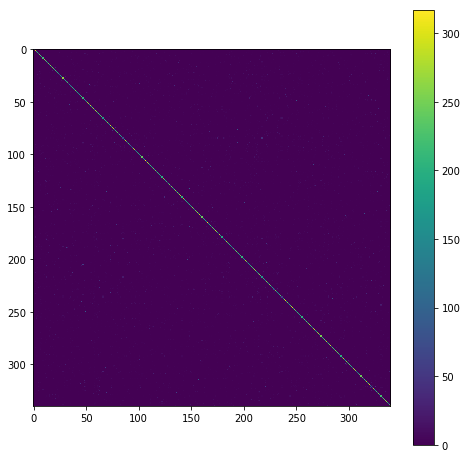

In [21]:
# evaluation metrics

test_cat = np.argmax(y_test, 1)
pred_y = lstm_model.predict(X_test, batch_size = batch_size)
pred_cat = np.argmax(pred_y, 1)

cm_ls = confusion_matrix(test_cat, pred_cat)

plt.figure(figsize=(8, 8))
plt.imshow(cm_ls, interpolation='nearest')
plt.colorbar()

cm = cm_ls.astype('float') / cm_ls.sum(axis=1)[:, np.newaxis]
cm_lstm = cm.diagonal()
#print("Accuracy of LSTM for each category ",cm_lstm)


print(classification_report(test_cat, pred_cat, target_names = [x for x in label_encoder.classes_]))

print("Three top accuracies: ", sorted(cm_lstm)[-3:])

# Ensemble Learning based on Confidence

The goal of ensemble learning here is to deploy the two classifiers of WaveNet and LSTM and boost their performance. The approach suggested here uses the probability (confidence) of these individual classifier. For each new sample, the category is predicted and its probability is calculated by each classifier independently. Then, for each classifier, this value is multiplied by the overall accuracy of that classifier and also the accuracy of that classifier for the predicted category. 

In [22]:
# ***overall confidence of the model:
# which is overall accuracy of individual classifier calulated over the "testing" data
conf_wavenet = wavenet_result[1]
conf_lstm = lstm_result[1]

This function recieves an input and outputs the category of the input using ensemble approach. This approach is explained step by step through the codes.

In [23]:
# ensemble approach
def ensemble_model_predict(x):
    
    # the output of drawing x is predicted. Here the output is a list of probabilities for all category.
    # LSTM and WaveNet are run independently.
    pred_y_wavenet = wavenet_model.predict(x)
    pred_y_lstm = lstm_model.predict(x)
    #print(pred_y_wavenet)
    
    # using argmax, the category with the maximum value of probability is selected. 
    # It is the predicted category for the given sample
    pred_cat_wavenet = np.argmax(pred_y_wavenet)
    pred_cat_lstm = np.argmax(pred_y_lstm)
    
    # ***the probability of predicted category is saved. This is the value that will be modified later.
    prop_y_wavenet = pred_y_wavenet[0][pred_cat_wavenet]
    prop_y_lstm = np.amax(pred_y_lstm, axis=1)[0]
    
    # ***overall predicted category confidence
    # Now we know the predicted category for each classifier.
    # We find the accuracy of each classifier for predicted category. 
    # This accuracy vector has been calculated earlier using confusion matrix over the "testing" data.
    accu_cat_wavenet = cm_wavenet[pred_cat_wavenet]
    accu_cat_lstm = cm_lstm[pred_cat_lstm]
    
    # new value of probabilities: 
    # which weighted using the overall confidence of the model and the overall predicted category confidence 
    new_conf_wavenet = prop_y_wavenet * conf_wavenet * accu_cat_wavenet
    new_conf_lstm = prop_y_lstm * conf_lstm * accu_cat_lstm
    
    # The weighted probebilities of the predicted y are compared.
    # the output of that model with the higher value of new probabily is selected as output
    if new_conf_wavenet > new_conf_lstm:
        return pred_cat_wavenet
    else:
        return pred_cat_lstm

This approach is slightly different from the previous one. Here we do prediction for the given input using WaveNet and LSTM separately. Then, we weighten the probability of all categories. To weighten them, we multiply the propbability of each category by its overall category confidence from confusion matrix of testing. Also, it is multiplied by the overall confidence of the classifier. The category with the highest value of weighted probability among both LSTM and WaveNet is selected as output.

In [36]:
# ensemble
def ensemble_model_predict_all_prob(x):
    pred_y_wavenet = wavenet_model.predict(x)
    pred_y_lstm = lstm_model.predict(x)
    #print(pred_y_wavenet)
    
    # new value of probabilities 
    # which weighted using the overall model confidence and the overall predicted category confidence 
    prop_conf_wavenet = np.array(pred_y_wavenet) * np.array(cm_wavenet) * conf_wavenet 
    prop_conf_lstm = np.array(pred_y_lstm) * np.array(cm_lstm) * conf_lstm 
    
    # predicted category for the given sample
    pred_cat_wavenet = np.argmax(prop_conf_wavenet)
    pred_cat_lstm = np.argmax(prop_conf_lstm)
    
    # probability of predicted category
    new_y_wavenet = prop_conf_wavenet[0][pred_cat_wavenet]
    new_y_lstm = prop_conf_lstm[0][pred_cat_lstm]
    
    #print(new_conf_wavenet)
    #print(new_conf_lstm)
    # The weighted probebilities of the predicted y are compared
    if new_y_wavenet > new_y_lstm:
        return pred_cat_wavenet
    else:
        return pred_cat_lstm

We use the above function to stack the prediction for all ensemble testing data.

The evaluation metrics including, precision, recall, f1-score as well as accuracy for each category are calculated here.

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000


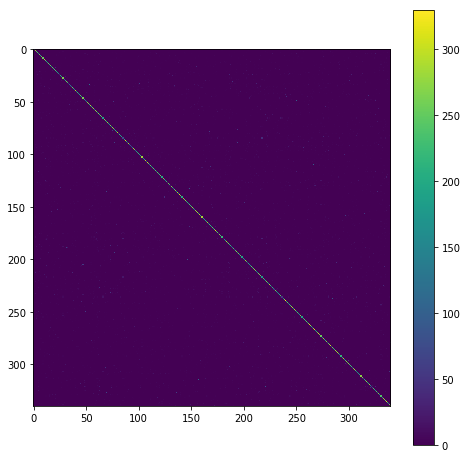

In [24]:
ensemble_pred_cat = []
c = 1

for x in X_ensemble:
    # to show the process 
    if c%10000==0:
        print(c)
    c += 1
    
    x = np.expand_dims(x, axis=0)

    pred_cat = ensemble_model_predict(x) # ensemble_model_predict_all_prob(x) 
    
    ensemble_pred_cat.append(pred_cat)
            

# ensemble learning evaluation metrics
ensemble_test_cat = np.argmax(y_ensemble, 1)

# confusion matrix
cm_ensemble = confusion_matrix(ensemble_test_cat, ensemble_pred_cat)
plt.figure(figsize=(8, 8))
plt.imshow(cm_ensemble, interpolation='nearest')
plt.colorbar()

# accuracy of each class
cm = cm_ensemble.astype('float') / cm_ensemble.sum(axis=1)[:, np.newaxis]
cm_ensemble = cm.diagonal()
#print(cm_ensemble)

# overall accuracy
accuracy_ensemble = cm_ensemble.mean()


In [25]:
#### Evaluation of Ensemble algorithm on ensemble test set

cm_ens = confusion_matrix(ensemble_test_cat, ensemble_pred_cat)

cm_ens = cm_ens.astype('float') / cm_ens.sum(axis=1)[:, np.newaxis]
cm_cat_ens = cm_ens.diagonal()
#print("Accuracy of Ensemble algorithm for each category ",cm_cat_ens)

# precision, recall, f1-score
print(classification_report(ensemble_test_cat, ensemble_pred_cat, target_names = [x for x in label_encoder.classes_]))

print("Three top accuracies: ", sorted(cm_cat_ens)[-3:])

                         precision    recall  f1-score   support

       The Eiffel Tower       0.77      0.90      0.83       333
The Great Wall of China       0.70      0.29      0.41       346
          The Mona Lisa       0.57      0.90      0.70       318
               airplane       0.65      0.78      0.71       315
            alarm clock       0.70      0.74      0.72       326
              ambulance       0.55      0.51      0.53       303
                  angel       0.66      0.79      0.72       327
       animal migration       0.55      0.61      0.58       324
                    ant       0.66      0.73      0.69       352
                  anvil       0.76      0.77      0.77       329
                  apple       0.76      0.87      0.81       335
                    arm       0.63      0.75      0.68       328
              asparagus       0.55      0.63      0.58       315
                    axe       0.69      0.61      0.65       330
               backpack 

In [26]:
# accuracy of wavenet and lstm separately on the ensemeble learning test data 
result = wavenet_model.evaluate(X_ensemble, y_ensemble, batch_size = batch_size)
accuracy_wavenet = result[1]
result = lstm_model.evaluate(X_ensemble, y_ensemble, batch_size = batch_size)
accuracy_lstm = result[1]

112200/112200 [==============================] - 12s 110us/step


In [97]:
print("Accuracy of WaveNet on the test set is ", accuracy_wavenet)
print("Accuracy of LSTM on the test set is ", accuracy_lstm)
print("Accuracy of Ensemble argorithm on the test set is ", accuracy_ensemble)

Accuracy of WaveNet on the test set is  0.6090374321223581
Accuracy of LSTM on the test set is  0.6126114085396344
Accuracy of Ensemble argorithm on the test set is  0.6353138836291583


In [27]:
#### Evaluation of WaveNet on ensemble test set

test_cat = np.argmax(y_ensemble, 1)
pred_y = wavenet_model.predict(X_ensemble, batch_size = batch_size)
pred_cat = np.argmax(pred_y, 1)

cm_wave_ens = confusion_matrix(test_cat, pred_cat)

cm_ens = cm_wave_ens.astype('float') / cm_wave_ens.sum(axis=1)[:, np.newaxis]
cm_wavenet_ens = cm_ens.diagonal()
#print("Accuracy of WaveNet for each category ",cm_wavenet_ens)

print(classification_report(test_cat, pred_cat, target_names = [x for x in label_encoder.classes_]))

print("Three top accuracies: ", sorted(cm_wavenet_ens)[-3:])

                         precision    recall  f1-score   support

       The Eiffel Tower       0.77      0.87      0.82       333
The Great Wall of China       0.60      0.35      0.44       346
          The Mona Lisa       0.69      0.83      0.76       318
               airplane       0.62      0.76      0.68       315
            alarm clock       0.64      0.71      0.67       326
              ambulance       0.49      0.54      0.51       303
                  angel       0.68      0.74      0.71       327
       animal migration       0.53      0.50      0.51       324
                    ant       0.63      0.72      0.67       352
                  anvil       0.73      0.72      0.72       329
                  apple       0.77      0.86      0.81       335
                    arm       0.66      0.68      0.67       328
              asparagus       0.57      0.57      0.57       315
                    axe       0.60      0.64      0.62       330
               backpack 

In [100]:
#### Evaluation of LSTM on ensemble test set

test_cat = np.argmax(y_ensemble, 1)
pred_y = lstm_model.predict(X_ensemble, batch_size = batch_size)
pred_cat = np.argmax(pred_y, 1)

cm_ls_ens = confusion_matrix(test_cat, pred_cat)

cm_ens = cm_ls_ens.astype('float') / cm_ls_ens.sum(axis=1)[:, np.newaxis]
cm_lstm_ens = cm_ens.diagonal()
#print("Accuracy of LSTM for each category ",cm_lstm)

print(classification_report(test_cat, pred_cat, target_names = [x for x in label_encoder.classes_]))

print("Three top accuracies: ", sorted(cm_lstm_ens)[-3:])

                         precision    recall  f1-score   support

       The Eiffel Tower       0.81      0.78      0.79       333
The Great Wall of China       0.41      0.25      0.31       346
          The Mona Lisa       0.59      0.87      0.70       318
               airplane       0.75      0.70      0.72       315
            alarm clock       0.69      0.64      0.67       326
              ambulance       0.52      0.41      0.46       303
                  angel       0.62      0.68      0.64       327
       animal migration       0.43      0.61      0.51       324
                    ant       0.75      0.66      0.70       352
                  anvil       0.73      0.68      0.70       329
                  apple       0.79      0.79      0.79       335
                    arm       0.58      0.67      0.62       328
              asparagus       0.44      0.61      0.51       315
                    axe       0.63      0.49      0.55       330
               backpack 

## To plot a random sample and predict its category using ensemble approach

In [120]:
# choose a sample to predict and plot
rand_idx = np.random.choice(range(size_ensemble), size = 1) 

# for the selected sample
x = X_ensemble[rand_idx]
pred_y = ensemble_model_predict(x)
print("The predicted class is: ", label_encoder.classes_[pred_y])
print("The actual class is: ", label_encoder.classes_[np.argmax(y_ensemble[rand_idx])])


The predicted class is:  toe
The actual class is:  toe


Text(0.5,1,'toe')

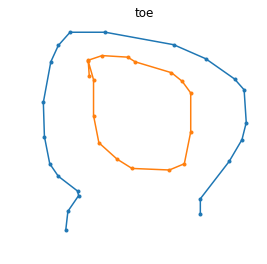

In [122]:
# visualization
# visualization
fig, ax = plt.subplots(1,1, figsize = (4, 4))

tmp = X_ensemble[rand_idx][0]
tmp = tmp[tmp[:,2]>0, :] 
idx = np.cumsum(tmp[:,2]-1)
for i in np.unique(idx):
    ax.plot(tmp[idx==i,0], np.max(tmp[:,1])-tmp[idx==i,1], '.-')
ax.axis('off')
ax.set_title(label_encoder.classes_[np.argmax(y_ensemble[rand_idx])])

# Accuracy visualization for different test sizes

In [58]:
def ensemble_score(X_, y_): 
    ensemble_pred_cat = []
    for x in X_:
        x = np.expand_dims(x, axis=0)
        pred_cat = ensemble_model_predict(x) # ensemble_model_predict_all_prob(x) 
        ensemble_pred_cat.append(pred_cat)            

    # ensemble learning evaluation metrics
    ensemble_test_cat = np.argmax(y_, 1)

    return accuracy_score(ensemble_test_cat,ensemble_pred_cat)

In [35]:
from sklearn.metrics import accuracy_score

df_visual = read_from_csv(5000, 8000, 1000)
df_visual['drawing'] = df_visual['drawing'].map(raw_2_xy_stroke)


In [50]:
def get_samples(size):
    df_visual_1 = [df_visual.sample(size)[['drawing', 'word']]]
    df_visual_1 = pd.concat(df_visual_1)
    X_= np.stack(df_visual_1['drawing'], 0)
    y_ = to_categorical(label_encoder.transform(df_visual_1['word'].values)) 
    return X_, y_

def get_scores(x, y):
    score = []

    wavenet_y = wavenet_model.predict(x, batch_size = batch_size)
    wavenet_cat = np.argmax(wavenet_y, 1)    
    score.append(accuracy_score(np.argmax(y, 1), wavenet_cat))

    lstm_y = lstm_model.predict(x, batch_size = batch_size)
    lstm_cat = np.argmax(lstm_y, 1)    
    score.append(accuracy_score(np.argmax(y, 1), lstm_cat))

    score.append(ensemble_score(x, y))
    print(score)
    return score

In [59]:
scores = []

for i in range(6):
    n_samples = 50000+i*50000
    print(n_samples)
    X_, y_ = get_samples(n_samples)
    scores.append(get_scores(X_, y_))

50000
[0.60932, 0.613, 0.6368]
100000
[0.60562, 0.60896, 0.63186]
150000
[0.6070133333333333, 0.6106466666666667, 0.6341533333333333]
200000
[0.60702, 0.6112, 0.633595]
250000
[0.607576, 0.611696, 0.634268]
300000
[0.6073566666666667, 0.61135, 0.6335233333333333]


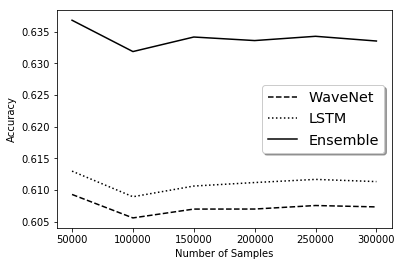

In [66]:
scores_alg = list(zip(*scores))
x_axis = np.linspace(50000, 300000, 6)

fig, ax = plt.subplots(figsize = (6, 4))
ax.plot(x_axis, scores_alg[0], 'k--', label='WaveNet')
ax.plot(x_axis, scores_alg[1], 'k:', label='LSTM')
ax.plot(x_axis, scores_alg[2], 'k', label='Ensemble')

legend = ax.legend(loc='center right', shadow=True, fontsize='x-large')
ax.set_xlabel('Number of Samples')
ax.set_ylabel('Accuracy')
plt.show()